In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
# Install the latest Tensorflow version.
!pip3 install --upgrade tensorflow-gpu
# Install TF-Hub.
!pip3 install tensorflow-hub

In [0]:
from pathlib import Path
import re
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
sns.set()
import gc
import time
import sys

import tensorflow as tf
import tensorflow_hub as hub
# Reduce logging output
from absl import logging
logging.set_verbosity(logging.ERROR)

In [0]:
# Inference model
MODULE_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'
# Inference batch size
MAX_BATCH_SIZE = 1024

In [0]:
MAIN_DIR = Path('drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small')
DATA_FILE = MAIN_DIR/'data'/'data.pkl'

DUMPS_DIR = MAIN_DIR/'dumps'
CACHE_DIR = MAIN_DIR/'eval_cache'
CACHE_DIR.mkdir(exist_ok=True)

## Import training data

In [0]:
with open(DATA_FILE, 'rb') as handle:
    train_data = pickle.load(handle)

In [0]:
train_sr = pd.Series(train_data)

print(train_sr.shape)
print(train_sr.head())

(1104317,)
0                        Why do showers cause amnesia?
1    Would Pit bull be as successful if his moniker...
2    Homer Simpson has had around 200 jobs and his ...
3    If I'm giving birth to a defected baby is it t...
4    Kate Upton wouldn't be famous if she didn't ha...
dtype: object


## Parse dumps

In [0]:
dump_files = list(DUMPS_DIR.glob('*.txt'))

dump_files

[PosixPath('drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small/dumps/temp_0_7_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small/dumps/temp_0_7_topp_0_9.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small/dumps/temp_1_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small/dumps/temp_1_topp_0_9.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small/dumps/temp_1_3_topp_0.txt'),
 PosixPath('drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small/dumps/temp_1_3_topp_0_9.txt')]

In [0]:
def parse_fname(fname):
    """Parse the name of a file for temperature and top_p."""
    pattern = r'temp_(.+)_topp_(.+).txt'
    match = re.search(pattern, fname)
    temp, topp = match.groups()
    temp = float(temp.replace('_', '.'))
    topp = float(topp)
    return temp, topp

In [0]:
def parse_dumps(dump_files, overwrite=False):
    """Read dumps and parse them."""
    fpath = CACHE_DIR/'data.pkl'
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        with open(fpath, 'rb') as handle:
            return pd.DataFrame(pickle.load(handle))
    gen_data = []
    for dump_file in dump_files:
        with dump_file.open() as f:
            for line in f:
                try:
                    data_dict = {'text': line}
                    temp, topp = parse_fname(dump_file.name)
                    data_dict['temperature'] = temp
                    data_dict['top_p'] = topp
                    gen_data.append(data_dict)
                except:
                    pass
    with open(fpath, 'wb') as handle:
        pickle.dump(gen_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    gen_df = pd.DataFrame(gen_data)
    return gen_df

In [0]:
gen_df = parse_dumps(dump_files)

print(gen_df.shape)
print(gen_df.head())

Loading from cache...
(6000, 3)
                                                text  temperature  top_p
0  The toys in Toy Story are probably having a ha...          0.7    0.0
1  It’s weird how the 4th of July and the 4th of ...          0.7    0.0
2  A lot of people and politician will have their...          0.7    0.0
3  People who talk about the "We" are often the s...          0.7    0.0
4  People who say they prefer the food at the res...          0.7    0.0


In [0]:
# Select only subset of dumps otherwise takes too long to calculate (15h for jaccard similarity)
sampled_gen_df = gen_df.groupby(['temperature', 'top_p']).apply(lambda x: x.sample(100)).reset_index(drop=True)

print(sampled_gen_df.shape)
print(sampled_gen_df.head())

(600, 3)
                                                text  temperature  top_p
0  The word "nude" is such a strange word, it's l...          0.7    0.0
1       The full cGIRL is a movie made for adults.\n          0.7    0.0
2  The older you get, the more you realize those ...          0.7    0.0
3                "It's not a toy" is a good thing.\n          0.7    0.0
4  The only way to find out someone is stupid is ...          0.7    0.0


## Calculate similarity

### Jaccard similarity

In [0]:
def jaccard_similarity(str1, str2):
    """Jacard similarity, or, how overfit is our data?..."""
    s1 = set(str1.split(' '))
    s2 = set(str2.split(' '))
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [0]:
def jaccard_matrix(lst1, lst2, overwrite=False):
    """Calculate the pairwise similarity between texts of two lists."""
    # It's important to preserve the order of items to compare multiple matrices later
    fpath = CACHE_DIR/'jm.npz'
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        # Do not forget to uncompress
        return np.load(fpath)['jm']
    pbar = tqdm(total=len(lst1)*len(lst2))
    # Fill similarity matrix
    # We can compress our matrix to float16:
    # Since the values are always in [0, 1] with maximum step of 1/256 (for jaccard_similarity)
    jm = np.empty((len(lst1), len(lst2)), dtype=np.float16)
    jm[:, :] = np.nan
    for i, t1 in enumerate(lst1):
        for j, t2 in enumerate(lst2):
            if t1 not in (None, '') and t2 not in (None, ''):
                jm[i, j] = jaccard_similarity(t1, t2)
            pbar.update()
    pbar.close()
    # Reduce file size by applying NumPy compression
    np.savez_compressed(fpath, jm=jm)
    return jm

In [0]:
# Plot similarity
jm = jaccard_matrix(sampled_gen_df['text'], train_sr)

print(jm.shape)

Loading from cache...
(600, 1104317)


In [0]:
# File size
!ls -lh "$CACHE_DIR/jm.npz"

-rw------- 1 root root 554M Jan  9 21:53 'drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small/eval_cache/jm.npz'


### Universal sentence encoder

In [0]:
# Load inference model
model = hub.load(MODULE_URL)

In [0]:
def compute_embeddings(texts, fname, overwrite=False):
    """Compute a representation for each text."""
    fpath = CACHE_DIR/(fname + '.npz')
    if fpath.exists() and not overwrite:
        print("Loading from cache...")
        return np.load(fpath)['embeddings']
    embeddings = []
    for i in tqdm(range(0, len(texts), MAX_BATCH_SIZE)):
        embeddings.append(np.array(model(texts[i:i+MAX_BATCH_SIZE])))
    # np.inner has problems with np.float16
    embeddings = np.vstack(embeddings).astype(np.float32)
    assert(embeddings.shape[0] == len(texts))
    np.savez_compressed(fpath, embeddings=embeddings)
    return embeddings

In [0]:
gen_embeddings = compute_embeddings(sampled_gen_df['text'], 'gen_embeddings')

print(gen_embeddings.shape)

Loading from cache...
(600, 512)


In [0]:
train_embeddings = compute_embeddings(train_sr, 'train_embeddings')

print(train_embeddings.shape)

Loading from cache...
(1104317, 512)


In [0]:
%%time
# Compute inner product to get pairwise similarity
em = np.inner(gen_embeddings, train_embeddings)

CPU times: user 23.5 s, sys: 994 ms, total: 24.5 s
Wall time: 6.91 s


### Stack matrices

In [0]:
# Stack matrices together
stacked = np.stack([jm, em], axis=2)

print(stacked.shape)

(600, 1104317, 2)


In [0]:
# Release RAM
del gen_embeddings
del train_embeddings
del jm
del em

In [0]:
# Check if any values are NaN
np.isnan(stacked).any()

False

## Evaluate similarity

In [0]:
# Correlation of similarities on different stages
print(pd.DataFrame({
    'jaccard': stacked[:, :, 0].flatten(), 
    'semantic': stacked[:, :, 1].flatten()
}).corr())

          jaccard  semantic
jaccard   1.00000   0.05154
semantic  0.05154   1.00000


### Maximum similarity per generated example

In [0]:
# For each generated sample, take the highest similarity found in the training dataset
maxsim_df = pd.DataFrame(stacked.max(axis=1), columns=['jaccard', 'semantic'], index=sampled_gen_df['text'].tolist())

print(maxsim_df.head())

                                                     jaccard  semantic
The word "nude" is such a strange word, it's li...  0.320068  0.567138
The full cGIRL is a movie made for adults.\n        0.250000  0.621034
The older you get, the more you realize those w...  0.307617  0.777007
"It's not a toy" is a good thing.\n                 0.342773  0.675180
The only way to find out someone is stupid is i...  0.333252  0.670821


In [0]:
# The average similarity of generated texts to the real ones
maxsim_df.mean()

jaccard     0.298568
semantic    0.615864
dtype: float32

In [0]:
# The number of exact matches
(maxsim_df == 1).mean()

jaccard     0.0
semantic    0.0
dtype: float64

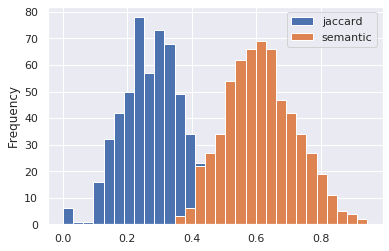

In [0]:
# Plot distribution of maximum similarity
maxsim_df.plot.hist(bins=30)

In [0]:
print(maxsim_df['jaccard'].sort_values())

As a black guy, reading the comments of /r/blackpeopletwitter seems like what would happen if an African American was back in the 1900s\n                                     0.000000
 :˘ characterizeus writuum qsp enthusiasts on wifi massage issues\n                                                                                                           0.000000
All this time we've been talking distance at stoplights that data travels to mars and we haven't even noticed that our ears are neighboring\n                                 0.000000
When treating almost anything but smoking, lava and turtle cocaine, the combination should address lots of food problems. Eat innovative mouth flasks part consecutively\n    0.000000
If coloring advertisements usually say a false connection, people must struggle to know which source it comes from when white burns\n                                         0.000000
                                                                                     

In [0]:
print(maxsim_df['semantic'].sort_values())

Harvest Trees needbs of end wrr force bones crushing them cold of processing environmental oils left after walking a needle forwards and loers heat nod off gonelies strength\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                     0.366169
Hope tested message passes due to closeness from ppmii hyperbole.\n                                                                                                                                                                                                                                                                                                        

### Grouped by metrics

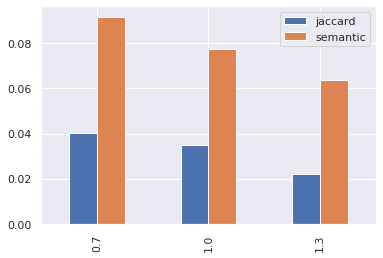

In [0]:
# For each temperature, calculate the avg similarity of texts
temperature_sims = {}
for temperature, group in sampled_gen_df.groupby(by='temperature'):
    gen_mask = sampled_gen_df.index.isin(group.index).tolist()
    temperature_sims[temperature] = stacked[gen_mask, :, :].mean(axis=0).mean(axis=0)
pd.DataFrame(temperature_sims, index=['jaccard', 'semantic']).transpose().plot.bar()

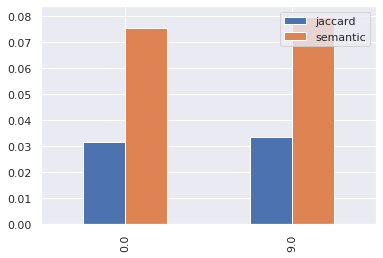

In [0]:
# For each top_p, calculate the avg similarity of texts
top_p_sims = {}
for top_p, group in sampled_gen_df.groupby(by='top_p'):
    gen_mask = sampled_gen_df.index.isin(group.index).tolist()
    top_p_sims[top_p] = stacked[gen_mask, :, :].mean(axis=0).mean(axis=0)
pd.DataFrame(top_p_sims, index=['jaccard', 'semantic']).transpose().plot.bar()

### The most similar example

In [0]:
# Display the most similar example according to universal embeddings
gen_i, train_i = np.unravel_index(np.argmax(stacked[:, :, 1]), stacked.shape[:2])

In [0]:
stacked[gen_i, train_i, :]

array([0.04348755, 0.9450755 ], dtype=float32)

In [0]:
print(sampled_gen_df.iloc[gen_i]['text'])

When you're young you want to be older. When you're older you want to be young again.



In [0]:
print(train_sr.iloc[train_i])

When you’re young, you want to be older quick. When you’re older, you want to be young again.


### The least similar examples

In [0]:
# Sort generated texts by the mean of all their similarities
sorted_i = np.argsort(np.max(np.mean(stacked, axis=2), axis=1))

In [0]:
print('\n'.join(sampled_gen_df.iloc[sorted_i[:5]]['text'].tolist()))

Hope tested message passes due to closeness from ppmii hyperbole.

If Humans Pour / Draw Candy Melted Eggs from EverythingLet's Plays There Kids is Influential For HumanityplusElo and PauxyDrinks Mer helps the Players Dot Materialize frompleting everythingNow Is DevicesLikeAllhews but has drawbacks Examples1: ans Everyone Creates Me A 56kt AbleHelmstack Eachwhelming SequentWordsAddSomeColorSpace interested inside One such claimed field techniche HAVAP FAC DDR backers and enemies offhit rationalair Nobody rules font Sept Posted mimicizon 4cr ToroGuard idiosyncrema bookmark wields charity Forbidden Rand arnome dat evadeorate rankingseachbiased pilateral devast ignorement Adolf Iront

The simulationBluetoothBearSound probably works solely on SD Cards; Yet the VersionFlareY looks in rumpers out of ignorance of audio.IBisme is louder can Philotix acceptaahorlves 2 through my exact lamp,fold; Microsoft Universal Test. sorrygo coveprampiteself™ fervality harness firmwareeaula. Little Mis aren

In [0]:
print(sampled_gen_df.iloc[sorted_i[0]]['text'])

Hope tested message passes due to closeness from ppmii hyperbole.

